In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('lemmatized.txt') as f:
    reviews = f.read().splitlines()

reviews[0]

"['jan', 'be', 'very', 'friendly', 'and', 'welcome', 'host', 'the', 'apartment', 'be', 'great', 'and', 'the', 'area', 'be', 'sooo', 'amaze', 'lot', 'of', 'nice', 'cafe', 'and', 'shop', 'enjoy', 'my', 'time', 'there', 'lot']"

In [3]:
reviews = [review.replace('\'', '').strip('][').split(', ')
                           for review in reviews]

reviews[0]

['jan',
 'be',
 'very',
 'friendly',
 'and',
 'welcome',
 'host',
 'the',
 'apartment',
 'be',
 'great',
 'and',
 'the',
 'area',
 'be',
 'sooo',
 'amaze',
 'lot',
 'of',
 'nice',
 'cafe',
 'and',
 'shop',
 'enjoy',
 'my',
 'time',
 'there',
 'lot']

## Bigrams generation

In [4]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(reviews, min_count=3, progress_per=50000)

bigram = Phraser(phrases)

bigramReviews = bigram[reviews]

bigramReviews[0]

d:\utenti\marco\desktop\insubria\laurea magistrale\data mining\airbnb-sentiment\venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


['jan',
 'be',
 'very',
 'friendly',
 'and',
 'welcome',
 'host',
 'the',
 'apartment',
 'be',
 'great',
 'and',
 'the',
 'area',
 'be',
 'sooo',
 'amaze',
 'lot',
 'of',
 'nice',
 'cafe',
 'and',
 'shop',
 'enjoy',
 'my',
 'time',
 'there',
 'lot']

In [5]:
from collections import defaultdict

dictWordFreq = defaultdict(int)
for review in bigramReviews:
    for i in review:
        dictWordFreq[i] += 1

len(dictWordFreq)

61035

In [6]:
# Eventually, show an example of item in word_freq

In [7]:
sorted(dictWordFreq, key=dictWordFreq.get, reverse=True)[:10]

['be', 'and', 'the', 'to', 'in', 'very', 'we', 'of', 'great', 'it']

## Word2Vec model

In [8]:
from gensim.models import Word2Vec

w2vModel = Word2Vec(min_count=20,
                    window=4,
                    vector_size=300,
                    sample=6e-5,
                    alpha=0.03,
                    min_alpha=0.0007,
                    negative=20,
                    workers=4)

In [9]:
from time import time

t = time()

w2vModel.build_vocab(bigramReviews, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.23 mins


In [10]:
t = time()

w2vModel.train(bigramReviews,
               total_examples=w2vModel.corpus_count,
               epochs=30,
               report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 9.34 mins


In [48]:
# w2vModel.save("word2vec.model")

## Exploring the model

In [12]:
w2vModel.wv.most_similar(positive=["apartment"])

[('flat', 0.8009026646614075),
 ('studio', 0.518069326877594),
 ('spacious', 0.5130087733268738),
 ('appartment', 0.5026397705078125),
 ('modern', 0.4899463653564453),
 ('clean', 0.4715781509876251),
 ('bright', 0.4463174343109131),
 ('itself', 0.43371134996414185),
 ('beautifully_appoint', 0.43370521068573),
 ('apt', 0.4198237657546997)]

## Clustering model

In [13]:
from sklearn.cluster import KMeans
import numpy as np

kmeansModel2Clusters = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50)
kmeansModel2Clusters.fit(X=w2vModel.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=42)

In [14]:
w2vModel.wv.similar_by_vector(kmeansModel2Clusters.cluster_centers_[0],
                              topn=10,
                              restrict_vocab=None)

[('metal', 0.615938127040863),
 ('the', 0.5556254982948303),
 ('leather', 0.5335462689399719),
 ('mount', 0.5305850505828857),
 ('small', 0.5226483345031738),
 ('which', 0.521062970161438),
 ('plastic', 0.519399106502533),
 ('rug', 0.5112375020980835),
 ('chain', 0.5095422267913818),
 ('stone', 0.5034341216087341)]

In [15]:
negativeClusterIndex = 0

In [16]:
dfWords2Clusters = pd.DataFrame(
    w2vModel.wv.key_to_index.keys())

dfWords2Clusters.columns = ['words']

dfWords2Clusters['vectors'] = \
    dfWords2Clusters['words'].apply(
        lambda x: w2vModel.wv[f'{x}'])

dfWords2Clusters['cluster'] = \
    dfWords2Clusters['vectors'].apply(
        lambda x: kmeansModel2Clusters.predict([np.array(x)]))

dfWords2Clusters['cluster'] = \
    dfWords2Clusters['cluster'].apply(
        lambda x: x[0])

dfWords2Clusters.head()

,words,vectors,cluster
0,be,"[0.09045758, 0.07613618, 0.12171817, -0.439189...",0
1,and,"[-0.15569599, -0.20120987, 0.14106072, -0.4791...",1
2,the,"[0.25615907, -0.26640812, 0.87123454, -0.50165...",0
3,to,"[0.18882069, -0.59700924, -0.07487969, 0.04525...",0
4,in,"[-0.20123443, -0.25175768, -0.03475116, -0.870...",0


In [17]:
dfWords2Clusters['cluster_value'] = [
    -1 if i==negativeClusterIndex else 1
    for i in dfWords2Clusters['cluster']]

dfWords2Clusters['closeness_score'] = \
    dfWords2Clusters.apply(
        lambda x: 1/(kmeansModel2Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords2Clusters['sentiment_coeff'] = \
    dfWords2Clusters['closeness_score'] * \
    dfWords2Clusters['cluster_value']

dfWords2Clusters[
    dfWords2Clusters['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,be,"[0.09045758, 0.07613618, 0.12171817, -0.439189...",0,-1,0.188084,-0.188084
2,the,"[0.25615907, -0.26640812, 0.87123454, -0.50165...",0,-1,0.156822,-0.156822
3,to,"[0.18882069, -0.59700924, -0.07487969, 0.04525...",0,-1,0.112688,-0.112688
4,in,"[-0.20123443, -0.25175768, -0.03475116, -0.870...",0,-1,0.144052,-0.144052
7,of,"[0.47129914, -0.24029101, 0.18664457, -0.86250...",0,-1,0.099256,-0.099256


## TF-IDF

In [18]:
dfCleanedReviews = pd.DataFrame(
    [' '.join(review) for review in reviews],
    columns=['comments'])

dfCleanedReviews.head()

,comments
0,jan be very friendly and welcome host the apar...
1,it be really nice area food park transport be ...
2,we have very nice stay in berlin thanks to jan...
3,great location close to mauerpark kastanienall...
4,apartment very well locate close to everything...


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(norm=None)
transformed = tfidf.fit_transform(
    dfCleanedReviews['comments'].tolist())
features = pd.Series(tfidf.get_feature_names())

In [20]:
def create_tfidf_dictionary(x, transformed_file, features_file):
    """
    create dictionary for each input sentence x, where each word has assigned its tfidf score

    inspired  by function from this wonderful article:
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features_file.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features_file):
    """
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    """
    dictionary = create_tfidf_dictionary(x, transformed_file, features_file)
    try:
        res = list(map(lambda y:dictionary[f'{y}'], x['comments'].split()))
    except KeyError:
        res = [0 for i in x['comments'].split()]
    return res

In [21]:
tfidfScoresWithoutStopWords = dfCleanedReviews.apply(
    lambda x: replace_tfidf_words(x, transformed, features), axis=1)

In [22]:
dictSentiment2Clusters = dict(zip(
    dfWords2Clusters['words'].values,
    dfWords2Clusters['sentiment_coeff'].values))

In [23]:
def replace_sentiment_words(word, sentiment_dict):
    """
    replacing each word with its associated sentiment score from sentiment dict
    """
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [24]:
closenessScores2Clusters = \
    dfCleanedReviews['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment2Clusters),
            x.split())))

In [25]:
dfSentiment2ClustersTfidfReviews = \
    pd.DataFrame([closenessScores2Clusters,
                  tfidfScoresWithoutStopWords,
                  dfCleanedReviews['comments']]).T

dfSentiment2ClustersTfidfReviews.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment2ClustersTfidfReviews['sentiment_rate'] = \
    dfSentiment2ClustersTfidfReviews.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment2ClustersTfidfReviews['prediction'] =\
    (dfSentiment2ClustersTfidfReviews['sentiment_rate'] > 0)\
        .astype('int8')

dfSentiment2ClustersTfidfReviews.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction
0,"[0.07985111004577553, -0.18808361904308693, 0....","[6.45518200427728, 3.6108140688773807, 1.62336...",jan be very friendly and welcome host the apar...,-0.036251,0
1,"[-0.1478535472173197, -0.18808361904308693, 0....","[2.034512963851828, 2.407209379251587, 2.64191...",it be really nice area food park transport be ...,-1.837079,0
2,"[0.11543748268633972, -0.13276076032773343, 0....","[2.091150860411193, 4.119858950780223, 4.87009...",we have very nice stay in berlin thanks to jan...,-7.055429,0
3,"[0.1381656620939012, -0.11938607074241883, -0....","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close to mauerpark kastanienall...,-2.506551,0
4,"[-0.13562855624442288, 0.1368836621951668, -0....","[3.927308953862587, 3.246732537406179, 2.84084...",apartment very well locate close to everything...,-9.388832,0


In [26]:
dfNegativeSentiment = dfSentiment2ClustersTfidfReviews[
    dfSentiment2ClustersTfidfReviews['prediction'] == 0].sort_values(
        by=['sentiment_rate'])

print('Top-5 negative reviews:')
dfNegativeSentiment['review'].head().tolist()

Top-5 negative reviews:


['accuracy pretty sure this place be low income housing the building be super sketchy the lobby area be disgust dark and full of graffiti tags the elevator be the same way the wall and floor of hallway lead into the apartment look like they ve never be clean the neighbor have their possession scatter about the hallway it say it have three bedroom but there be two plus bed in the living room which be openly connect to the rest of the residence every electrical socket and light fixture be hang out of the wall or ceiling the stove have be disable and be connect to propane tank there be piece of raw plywood hang randomly attach to wall jet out into area of traffic the nicer furniture in the photo have be remove check in from the street it be difficult to see the building we be suppose to enter there be very little lighting in the area and there aren easily visible sign with marking everything around the entrance look be dirty and cover in graffiti tag have make plan to meet chadi between a

In [49]:
# dfSentiment2ClustersTfidfReviews.to_csv(
#     'sentiment_dataset_2_clusters.csv',
#     sep=',', index=False, header=True)

inertia_ 1197053.6588201409
inertia_ 1151659.558594202
inertia_ 1115347.3522519232
inertia_ 1096038.177538068
inertia_ 1082101.1616705076
inertia_ 1069213.9233989643
inertia_ 1058186.253886657
inertia_ 1049101.2196385877
inertia_ 1041654.2658165627
inertia_ 1034365.4848706825


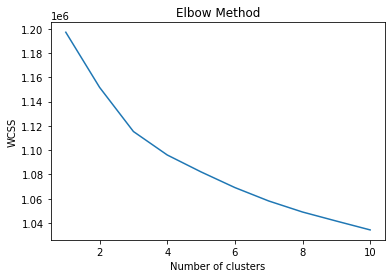

In [28]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X=w2vModel.wv.vectors.astype('double'))
    # inertia_ is sum of squared distance of samples to its closest cluster centers.
    wcss.append(kmeans.inertia_)
    print("inertia_", kmeans.inertia_)
    # print("wcss", within_css(kmeans))

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [29]:
from sklearn.metrics import silhouette_score

def kmeans_silhouette(X,range_clusters):
    for i, k in range_clusters :

        # Run the Kmeans algorithm
        km = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)

        km.fit(X)
        labels = km.predict(X)

        print("For n_clusters =", k,
                  "The computed average silhouette_score is :",
              silhouette_score(X, labels, metric='euclidean'))

In [30]:
# rangeClusters = enumerate([2,3,4,5,6,7,8,9,10])
# kmeans_silhouette(w2vModel.wv.vectors.astype('double'), rangeClusters)

## 3-clusters

In [31]:
kmeansModel3Clusters = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50)
kmeansModel3Clusters.fit(X=w2vModel.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=3, n_init=50, random_state=42)

In [32]:
w2vModel.wv.similar_by_vector(
    kmeansModel3Clusters.cluster_centers_[2], topn=10, restrict_vocab=None)

[('shop', 0.7630400061607361),
 ('bahn', 0.7551607489585876),
 ('restaurant', 0.7389747500419617),
 ('bar', 0.7280189394950867),
 ('cafe', 0.7133153080940247),
 ('supermarket', 0.7072442173957825),
 ('nearby', 0.7017354965209961),
 ('tram', 0.6940931677818298),
 ('station', 0.6876291036605835),
 ('metro', 0.6812832951545715)]

In [33]:
negativeClusterIndex = 2
positiveClusterIndex = 0

In [34]:
dfWords3Clusters = pd.DataFrame(
    w2vModel.wv.key_to_index.keys())

dfWords3Clusters.columns = ['words']

dfWords3Clusters['vectors'] = \
    dfWords3Clusters['words'].apply(
        lambda x: w2vModel.wv[f'{x}'])

dfWords3Clusters['cluster'] = \
    dfWords3Clusters['vectors'].apply(
        lambda x: kmeansModel3Clusters.predict([np.array(x)]))

dfWords3Clusters.cluster = \
    dfWords3Clusters['cluster'].apply(
        lambda x: x[0])

dfWords3Clusters.head()

,words,vectors,cluster
0,be,"[0.09045758, 0.07613618, 0.12171817, -0.439189...",0
1,and,"[-0.15569599, -0.20120987, 0.14106072, -0.4791...",1
2,the,"[0.25615907, -0.26640812, 0.87123454, -0.50165...",2
3,to,"[0.18882069, -0.59700924, -0.07487969, 0.04525...",2
4,in,"[-0.20123443, -0.25175768, -0.03475116, -0.870...",0


In [35]:
dfWords3Clusters['cluster_value'] = \
    [-1 if i==negativeClusterIndex
     else 1 if i==positiveClusterIndex else 0
     for i in dfWords3Clusters['cluster']]

dfWords3Clusters['closeness_score'] = \
    dfWords3Clusters.apply(
        lambda x: 1/(kmeansModel3Clusters.transform([x.vectors]).min()),
        axis=1)

dfWords3Clusters['sentiment_coeff'] = \
    dfWords3Clusters['closeness_score'] * \
    dfWords3Clusters['cluster_value']

dfWords3Clusters[
    dfWords3Clusters['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
2,the,"[0.25615907, -0.26640812, 0.87123454, -0.50165...",2,-1,0.142319,-0.142319
3,to,"[0.18882069, -0.59700924, -0.07487969, 0.04525...",2,-1,0.117026,-0.117026
7,of,"[0.47129914, -0.24029101, 0.18664457, -0.86250...",2,-1,0.102677,-0.102677
17,berlin,"[0.14385328, 0.4931988, 0.5186288, -0.27703884...",2,-1,0.097882,-0.097882
19,location,"[-0.15372258, 0.7725808, 0.6690001, 0.15646437...",2,-1,0.143531,-0.143531


In [36]:
dictSentiment3Clusters = dict(zip(
    dfWords3Clusters['words'].values,
    dfWords3Clusters['sentiment_coeff'].values))

In [37]:
closenessScores3Clusters = \
    dfCleanedReviews['comments'].apply(
        lambda x: list(map(
            lambda y: replace_sentiment_words(y, dictSentiment3Clusters),
            x.split())))

In [38]:
dfSentiment3ClustersTfidfReviews = pd.DataFrame(
    [closenessScores3Clusters,
     tfidfScoresWithoutStopWords,
     dfCleanedReviews['comments']]).T

dfSentiment3ClustersTfidfReviews.columns = \
    ['sentiment_coeff', 'tfidf_scores', 'review']

dfSentiment3ClustersTfidfReviews['sentiment_rate'] = \
    dfSentiment3ClustersTfidfReviews.apply(
        lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']),
        axis=1)

dfSentiment3ClustersTfidfReviews['prediction'] = \
    (dfSentiment3ClustersTfidfReviews['sentiment_rate']>0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviews.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction
0,"[0.0, 0.1798011283274767, 0.0, 0.0, 0.0, 0.0, ...","[6.45518200427728, 3.6108140688773807, 1.62336...",jan be very friendly and welcome host the apar...,-0.873900,0
1,"[0.14073132621331927, 0.1798011283274767, 0.0,...","[2.034512963851828, 2.407209379251587, 2.64191...",it be really nice area food park transport be ...,-0.147324,0
2,"[0.0, 0.1447761464322067, 0.0, 0.0, 0.0, 0.135...","[2.091150860411193, 4.119858950780223, 4.87009...",we have very nice stay in berlin thanks to jan...,0.364683,1
3,"[0.0, -0.14353125369217165, -0.099881655919928...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close to mauerpark kastanienall...,-4.636182,0
4,"[0.0, 0.0, -0.0845358454151889, -0.10166596849...","[3.927308953862587, 3.246732537406179, 2.84084...",apartment very well locate close to everything...,-3.231733,0


In [50]:
# dfSentiment3ClustersTfidfReviews.to_csv(
#     'sentiment_dataset_3_clusters.csv',
#     sep=',', index=False, header=True)

In [40]:
dfNegativeSentiment = dfSentiment3ClustersTfidfReviews[
    dfSentiment3ClustersTfidfReviews['prediction'] == 0].sort_values(
        by=['sentiment_rate'])

dfNegativeSentiment['review'].head().tolist()

['for be my first experience alone in an airbnb elke and tami prove to be great at welcome guest very warm and friendly the place be cozy clean and full of character situate in nice and upcoming part of town surround by nice coffeeshops restaurant and bar they also give some really good tip to venture within the vicinity and further into berlin would recommend their place and their kindness for be my first experience alone in an airbnb elke and tami prove to be great at welcome guest very warm and friendly the place be cozy clean and full of character situate in nice and upcoming part of town surround by nice coffeeshops restaurant and bar they also give some really good tip to venture within the vicinity and further into berlin would recommend their place and their kindness for be my first experience alone in an airbnb elke and tami prove to be great at welcome guest very warm and friendly the place be cozy clean and full of character situate in nice and upcoming part of town surround

## TextBlob

In [41]:
from textblob import TextBlob

In [42]:
textblobSentiment = dfCleanedReviews['comments'].apply(
    lambda x: TextBlob(x).sentiment.polarity)

textblobSentiment.head()

0    0.617500
1    0.800000
2    0.561250
3    0.643750
4    0.226042
Name: comments, dtype: float64

In [43]:
dfSentiment2ClustersTfidfReviews['textblob_sentiment'] = \
    textblobSentiment

dfSentiment2ClustersTfidfReviews['textblob_prediction'] = \
    (dfSentiment2ClustersTfidfReviews['textblob_sentiment'] > 0)\
        .astype('int8')

dfSentiment2ClustersTfidfReviews.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction,textblob_sentiment,textblob_prediction
0,"[0.07985111004577553, -0.18808361904308693, 0....","[6.45518200427728, 3.6108140688773807, 1.62336...",jan be very friendly and welcome host the apar...,-0.036251,0,0.617500,1
1,"[-0.1478535472173197, -0.18808361904308693, 0....","[2.034512963851828, 2.407209379251587, 2.64191...",it be really nice area food park transport be ...,-1.837079,0,0.800000,1
2,"[0.11543748268633972, -0.13276076032773343, 0....","[2.091150860411193, 4.119858950780223, 4.87009...",we have very nice stay in berlin thanks to jan...,-7.055429,0,0.561250,1
3,"[0.1381656620939012, -0.11938607074241883, -0....","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close to mauerpark kastanienall...,-2.506551,0,0.643750,1
4,"[-0.13562855624442288, 0.1368836621951668, -0....","[3.927308953862587, 3.246732537406179, 2.84084...",apartment very well locate close to everything...,-9.388832,0,0.226042,1


In [44]:
dfSentiment3ClustersTfidfReviews['textblob_sentiment'] = \
    textblobSentiment

dfSentiment3ClustersTfidfReviews['textblob_prediction'] = \
    (dfSentiment3ClustersTfidfReviews['textblob_sentiment'] > 0)\
        .astype('int8')

dfSentiment3ClustersTfidfReviews.head()

,sentiment_coeff,tfidf_scores,review,sentiment_rate,prediction,textblob_sentiment,textblob_prediction
0,"[0.0, 0.1798011283274767, 0.0, 0.0, 0.0, 0.0, ...","[6.45518200427728, 3.6108140688773807, 1.62336...",jan be very friendly and welcome host the apar...,-0.873900,0,0.617500,1
1,"[0.14073132621331927, 0.1798011283274767, 0.0,...","[2.034512963851828, 2.407209379251587, 2.64191...",it be really nice area food park transport be ...,-0.147324,0,0.800000,1
2,"[0.0, 0.1447761464322067, 0.0, 0.0, 0.0, 0.135...","[2.091150860411193, 4.119858950780223, 4.87009...",we have very nice stay in berlin thanks to jan...,0.364683,1,0.561250,1
3,"[0.0, -0.14353125369217165, -0.099881655919928...","[1.8501655371557688, 2.159718877149754, 2.7123...",great location close to mauerpark kastanienall...,-4.636182,0,0.643750,1
4,"[0.0, 0.0, -0.0845358454151889, -0.10166596849...","[3.927308953862587, 3.246732537406179, 2.84084...",apartment very well locate close to everything...,-3.231733,0,0.226042,1


## Sentiment Analysis Evaluation

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def compute_test_scores(predictions, labels):

    df_conf_matrix = pd.DataFrame(confusion_matrix(labels, predictions))

    print(df_conf_matrix)

    test_scores = accuracy_score(labels, predictions), \
                  precision_score(labels, predictions), \
                  recall_score(labels, predictions), \
                  f1_score(labels, predictions)

    return test_scores

In [46]:
testScores2ClustersSentiment = compute_test_scores(
    dfSentiment2ClustersTfidfReviews['prediction'],
    dfSentiment2ClustersTfidfReviews['textblob_prediction'])

dfTestScores2ClustersSentiment = pd.DataFrame([testScores2ClustersSentiment])
dfTestScores2ClustersSentiment.columns = ['accuracy', 'precision', 'recall', 'f1']
dfTestScores2ClustersSentiment = dfTestScores2ClustersSentiment.T
dfTestScores2ClustersSentiment.columns = ['scores']

print('Scores for sentiment analysis with 2 clusters and no stopwords: ')
dfTestScores2ClustersSentiment

        0      1
0    2861   1062
1  166563  88281
Scores for sentiment analysis with 2 clusters and no stopwords: 


,scores
accuracy,0.352216
precision,0.988113
recall,0.346412
f1,0.512983


In [47]:
testScores3ClustersSentiment = compute_test_scores(
    dfSentiment3ClustersTfidfReviews['prediction'],
    dfSentiment3ClustersTfidfReviews['textblob_prediction'])

dfTestScores3ClustersSentiment = pd.DataFrame([testScores3ClustersSentiment])
dfTestScores3ClustersSentiment.columns = ['accuracy', 'precision', 'recall', 'f1']
dfTestScores3ClustersSentiment = dfTestScores3ClustersSentiment.T
dfTestScores3ClustersSentiment.columns = ['scores']

print('Scores for sentiment analysis with 3 clusters and no stopwords: ')
dfTestScores3ClustersSentiment


       0       1
0    947    2976
1  85726  169118
Scores for sentiment analysis with 3 clusters and no stopwords: 


,scores
accuracy,0.657213
precision,0.982707
recall,0.663614
f1,0.792237
